In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, LinearRegression
import xgboost as xgb
from config import create_connection_obj

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [2]:
conn = create_connection_obj()

df = pd.read_sql(sql="SELECT * FROM tidyredfin_data;", con=conn)

In [3]:
# functions
def rmse(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

def dummy_encode_zipcode(df):
    most_frequent_zip_codes = [97209, 97201, 97239, 97217, 97210, 97219]

    for zipcode in most_frequent_zip_codes:
        df['zip_' + str(zipcode)] = 1 * (df['ZIPCODE'] == zipcode)
    return df

def dummy_encode_address_direction(df):
    return (
        pd.concat([df, pd.get_dummies(df['address_direction'], drop_first=False)], axis=1)
        .drop(['E', 'N', 'W', 'S', 'address_direction'], axis=1)
    )

def rmse_cv(model, data, target):
    scores = cross_val_score(model, data, target, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    print("Scores: ", rmse_scores)
    print("Mean: ", rmse_scores.mean())
    print("Std: ", rmse_scores.std())
   
def process_data_for_model(df):
    df = df.dropna() # Drop missing values since they're so few and look randomly distributed

    return (
        df
        .assign(months_since_2021=np.where(df['SOLD_YEAR'] == 2022, df['SOLD_MONTH'] + 12, df['SOLD_MONTH'])) # Standardize sale date to numeric
        .pipe(dummy_encode_address_direction) # Make dummy variables for address direction
        .pipe(dummy_encode_zipcode) # dummy encode the 6 most frequent zipcodes
        .drop(['index', 'SOLD_YEAR', 'SOLD_MONTH', 'ADDRESS', 'ZIPCODE', 'address_building'], axis=1) # drop unnecessary columns
    )

In [4]:
model_data = process_data_for_model(df)

/home/buchmayne/anaconda3/envs/condo/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


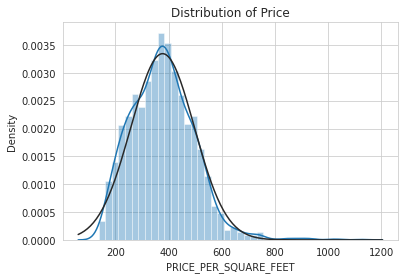

In [5]:
sns.distplot(model_data['PRICE_PER_SQUARE_FEET'], fit=stats.norm)
plt.title('Distribution of Price')
plt.show()

/home/buchmayne/anaconda3/envs/condo/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


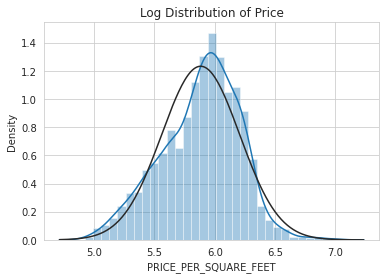

In [8]:
sns.distplot(np.log(model_data['PRICE_PER_SQUARE_FEET']), fit=stats.norm)
plt.title('Log Distribution of Price')
plt.show()

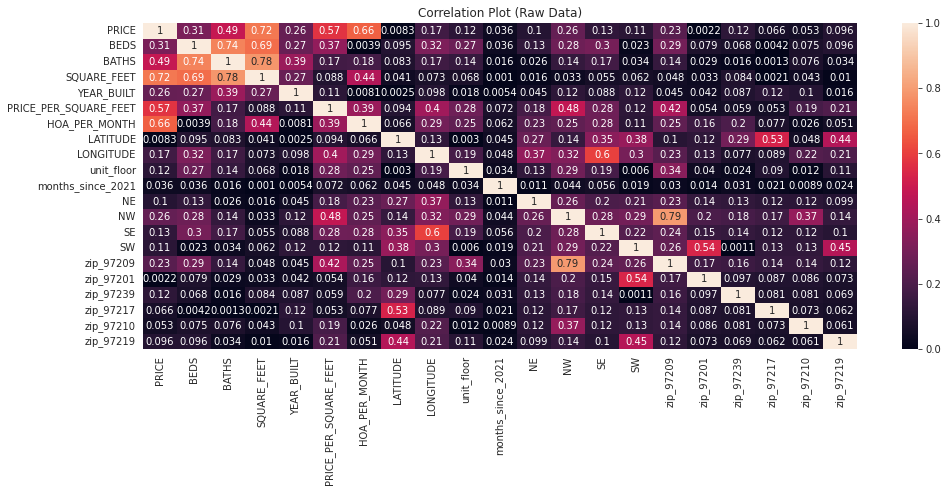

In [9]:
numeric_corr_raw = model_data.corr().abs()

plt.figure(figsize=(16, 6))
sns.heatmap(numeric_corr_raw, vmin=0, vmax=1, annot=True)
plt.title('Correlation Plot (Raw Data)')
plt.show()

In [10]:
X = model_data.drop(['PRICE', 'PRICE_PER_SQUARE_FEET'], axis=1)
y = model_data['PRICE_PER_SQUARE_FEET']

X = sm.add_constant(X)

regression = sm.OLS(y, X).fit()

print(f"OLS RMSE: ${rmse(y, regression.predict(X)).round()}")

OLS RMSE: $83.0


In [12]:
X = model_data.drop(['PRICE', 'PRICE_PER_SQUARE_FEET'], axis=1)
y = model_data['PRICE_PER_SQUARE_FEET']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

In [17]:
knn = KNeighborsRegressor()

model_params = {
    'model__n_neighbors': [7],
    'model__weights': ['distance']
}

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', knn)
])

knn_grid_search = GridSearchCV(knn_pipeline, model_params)
knn_grid_search.fit(X_train, y_train)


rmse_cv(model=knn_grid_search, data=X_train, target=y_train)

Scores:  [68.21638202 69.83046452 70.13877657 68.35093039 63.10513467]
Mean:  67.92833763137068
Std:  2.530966930415554


In [18]:
knn_grid_search.best_params_

{'model__n_neighbors': 7, 'model__weights': 'distance'}

In [19]:
gb_trees = xgb.XGBRegressor(random_state=1)

model_params = {
    'model__eta': [0.3, 0.2, 0.1, 0.05, 0.01],
    'model__max_depth': [3, 5, 6, 7, 9],
    'model__lambda': [1, 0.9, 0.7, 0.5]
}

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', gb_trees)
])

xgb_grid_search = GridSearchCV(xgb_pipeline, model_params)
xgb_grid_search.fit(X_train, y_train)


rmse_cv(model=xgb_grid_search, data=X_train, target=y_train)

Scores:  [53.61617562 53.34368704 57.74677638 56.50079437 52.71780852]
Mean:  54.785048386751285
Std:  1.971440271560891


In [20]:
xgb_grid_search.best_params_

{'model__eta': 0.1, 'model__lambda': 1, 'model__max_depth': 6}

In [21]:
ridge = Ridge()

model_params = {
    'model__alpha': [1, 0.5, 0.1]
}

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ridge)
])

ridge_grid_search = GridSearchCV(ridge_pipeline, model_params)
ridge_grid_search.fit(X_train, y_train)


rmse_cv(model=ridge_grid_search, data=X_train, target=y_train)

Scores:  [82.62899844 86.27068141 85.26212354 87.89070601 76.81089258]
Mean:  83.77268039487087
Std:  3.877913945506821


In [22]:
ridge_grid_search.best_params_

{'model__alpha': 1}

In [23]:
lin_reg = LinearRegression()

lin_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', lin_reg)
])

lin_reg_pipeline.fit(X_train, y_train)

rmse_cv(model=lin_reg_pipeline, data=X_train, target=y_train)

Scores:  [82.62724649 86.27718046 85.27052039 87.87984261 76.83308015]
Mean:  83.77757402042093
Std:  3.86923189638832


In [31]:
gb_trees_best_ = xgb.XGBRegressor(
    random_state=1,
    eta=xgb_grid_search.best_params_['model__eta'],
    max_depth=xgb_grid_search.best_params_['model__max_depth'],
    reg_lambda=xgb_grid_search.best_params_['model__lambda']
)


xgb_pipeline_best_ = Pipeline([
    ('scaler', StandardScaler()),
    ('model', gb_trees_best_)
])


xgb_pipeline_best_.fit(X_train, y_train)

predicted_sales_price = xgb_pipeline_best_.predict(X_train)

review_resids = (
    X_train
    .assign(
        y=y_train,
        y_hat=predicted_sales_price,
        resids=y_train - predicted_sales_price,
        pct_resids=(y_train - predicted_sales_price) / y_train
    )
)

In [38]:
(
    review_resids
    .assign(
        error_bins=pd.qcut(review_resids['pct_resids'], q=10)
    )
    .groupby(['error_bins'])
    .agg(
        avg_sales_price=('y', 'mean'),
        avg_pred=('y_hat', 'mean'),
        median_sales_price=('y', 'median'),
        median_pred=('y_hat', 'median'),
        median_year_built=('YEAR_BUILT', 'median'),
        median_sqft=('SQUARE_FEET', 'median'),
    )
)

,avg_sales_price,avg_pred,median_sales_price,median_pred,median_year_built,median_sqft
error_bins,,,,,,
"(-0.386, -0.0888]",291.712644,333.294800,286.0,332.973145,1995.5,1114.5
"(-0.0888, -0.0526]",331.643678,354.128510,339.0,361.888885,1995.5,996.0
"(-0.0526, -0.031]",332.734104,346.298492,332.0,344.130585,2000.0,1008.0
"(-0.031, -0.0164]",359.028736,367.351593,363.5,371.637909,2001.0,1037.0
"(-0.0164, -0.00173]",367.543353,370.870544,377.0,378.959717,2005.0,1006.0
"(-0.00173, 0.0104]",376.379310,374.730347,362.5,362.001312,2001.0,993.0
"(0.0104, 0.0227]",404.439306,397.752075,400.0,395.287262,2001.0,982.0
"(0.0227, 0.0403]",410.488506,397.526794,406.0,392.596497,2001.0,979.0
"(0.0403, 0.0667]",421.352601,399.367279,428.0,401.418091,1999.0,1043.0


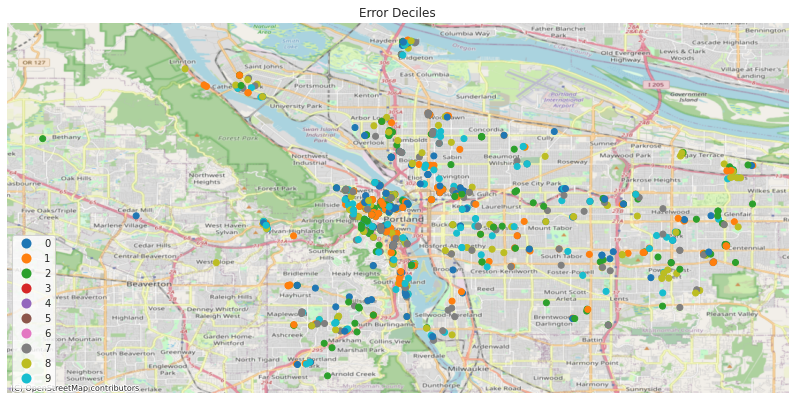

In [53]:
ax = (
    review_resids
    .assign(
        error_bins=pd.qcut(review_resids['pct_resids'], q=10, labels=range(10)),
        geos=lambda df_:list(zip(df_['LONGITUDE'], df_['LATITUDE']))
    )
    .pipe(lambda df_: df_.loc[(
        (df_['error_bins'] == 0)
        | (df_['error_bins'] == 1)
        | (df_['error_bins'] == 2)
        | (df_['error_bins'] == 7)
        | (df_['error_bins'] == 8)
        | (df_['error_bins'] == 9)
    )])
    .pipe(lambda df_:
        gpd.GeoDataFrame(df_, geometry=[Point(xy) for xy in df_['geos']], crs="EPSG:4269")
    )
    .plot(column='error_bins', legend=True, figsize=(14,14))
    
)


ctx.add_basemap(ax=ax, crs="EPSG:4269", source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')
plt.title('Error Deciles')
plt.show()

MODELING TO DO:

* More feature engineering: 
    
    * repeat modeling with log transformed price
    
    * add distance to downtown (duplicative?) and distance to Willamete River // doesn't seem to be a lot of spatial clustering in errors though
    
    * model seems to perform poorly with older units and larger units, seems like a good time to try and dig as deep as possible to solution of expensive + old + big units. How to identify the premium associated with very old but well kept NW condos?
    

* Get SHAP values for XGB
